#**Group 186 - DM Assignment - Change of Primary Care Physician**

**Problem statement:** <br>
US patients intend to change their Primary Care Physician (General Family doctor in Indian terms). This requires significant effort for the health insurance provider. 
The problem statement here is to understand why patients are likely to leave the recommended PCP and further suggest another Physician that they are less likely to leave.
We have a subset of the insurance provider data along with PCP changes.

**Data Description**
<table>
  <tr><th>Variable</th><th>Description</th></tr>
  <tr>
      <td>Outcome<br> [0|1]</td>
      <td>Member changed to his/her preferred primary care provider instead of auto assigned to provider.<br>0: Member keeps the auto assigned provider.<br>1: Member changed to this provider by calling customer service.</td>
  </tr>
  <tr>
    <td>distance</td>
    <td>Distance between member and provider in miles.</td>
  </tr>
  <tr>
    <td>visit_count</td>
    <td>Number of claims between member and provider.</td>
  </tr>
  <tr>
    <td>claims_days_away</td>
    <td>Days between member changed to / assigned to the provider and latest claim between member and provider.</td>
  </tr>
  <tr>
    <td>tier<br>[1|2|3|4]</td>
    <td>Provider Tier from service. Tier 1 is highest benefit level and most cost-effective level.</td>
  </tr>
  <tr>
    <td>fqhc<br>[0|1]</td>
    <td>Provider is a certified Federally Qualified Health Center or not</td>
  </tr>
  <tr>
    <td>pcp_lookback<br>[0|1]</td>
    <td>he provider was the member primary care provider before or not</td>
  </tr>
  <tr>
    <td>family_Assignment<br>[0|1]</td>
    <td>The provider is the pcp of the member in the same family or not</td>
  </tr>
  <tr>
    <td>kid<br>[0|1]</td>
    <td>Member is a kid. (under 18 for state of New York)</td>
  </tr>
  <tr>
    <td>is_Ped<br>[0|1]</td>
    <td>Provider is a pediatrician or not</td>
  </tr>
  <tr>
    <td>same_gender</td>
    <td>provider and member are the same gender or not</td>
  </tr>
  <tr>
    <td>same_language</td>
    <td>Provider and member speak the same language or not</td>
  </tr>
  <tr>
    <td>same_address</td>
    <td>The re-assigned provider has the same address as the provider pre-assigned.</td>
  </tr>
</table>

# The proposed Methodology and Solution

Lets include the required imports.

Libraries used in this solution (As per the requirement, we can python for implementation, and use any ML/Python Libraries as well): *sklearn,imblearn,pandas,numpy,seaborn,matplotlib*
- sklearn library includes efficient tools for machine learning and statistical modeling including classification, regression, clustering and dimensionality reduction via a consistence interface in Python.
- NumPy library is used for working with arrays. It also has functions for working in domain of linear algebra, fourier transform, and matrices.
- Imbalanced-learn (imblearn) relies on scikit-learn (imported as sklearn) and provides tools when dealing with classification with imbalanced classes.
- Matplotlib is a graphical plotting library and a numerical extension NumPy.
- Pandas library is used to analyze data.
- Seaborn is used in this solution for data visualization and is based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.


In [37]:
from sklearn.model_selection import KFold,StratifiedKFold,RepeatedStratifiedKFold
from sklearn.metrics import fbeta_score
from sklearn.feature_selection import SelectKBest,chi2
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler,KBinsDiscretizer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer,SimpleImputer
from sklearn.linear_model import BayesianRidge,LogisticRegression,SGDClassifier
from sklearn.svm import LinearSVC
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Utility methods

### is_categorical 
used to check if a variable is categorical or not<br>
Signature:<br>
```
Method name: is_categorical
Params: 
  data - DataFrame generated from the csv file
  columnName - featureName/ columnName which needs to be checked
Returns:
  bool - true if the column/feature is categorical else false

```

In [38]:
MAX_UNIQUE_VALUES_FOR_CATEGORICAL=7
def is_categorical(data, columnName):
  return len(data[columnName].unique()) < MAX_UNIQUE_VALUES_FOR_CATEGORICAL

### get_percentage
This method returns the percent of datapoints that a feature `featureName` takes a value `featureVal`, for a `targetName` taking a value `targetVal` <br>
Ex: say for column is_kid and target outcome = 1<br>
48% of members(kid) request for a change
```
Method name: get_percentage
Params:
  data : inputData in the form of DataFrame
  featureName: name of the feature 
  featureVal: value that a feature takes
  targetName: name of the target column
  targetVal: value that target column takes
Returns:
  percentage rounded of to 2 decimals

```

In [39]:
def get_percentage(data,featureName,featureVal,targetName,targetVal):
  needed_data=data.loc[(data[featureName]==featureVal)&(data[targetName]==targetVal)]
  records_in_target_class=len(data.loc[data[targetName]==targetVal])
  perc=round(100*len(needed_data)/(1.0*records_in_target_class),2)
  return perc

### compare_features
This function returns a comparison by percentage of the data distribution for a target variable for all possible values of a feature.
If the feature is continuous, then it is discretized into certain number of classes, which is then encoded.<br>
```javascript
Method name: compare_features
Params:
  new_data: input data in the form of DataFrame
  selected_features : features which is selected by the model
  target_label: target column name
Returns:
  report - which contains description by percentage for all the features
  report is of the form
  {
    "features: [
          {
            "name": "featureName",
            "type" : "categorical|continuous",
            "classDescription" : [ /*For each value that the target class takes */
              {
                "targetValue" : "0",
                "description":[ /* For each value the feature takes, provided the target class is given */
                  {"featureVal": 0, "percentage": 56.1},...
                ]
              },
              {
                "targetValue" : "1",
                "description":[
                  {"featureVal": 0, "percentage": 72.8},...
                ]
              }
            ]
          },...
    ]
  }

```

In [40]:
def compare_features(new_data,selected_features,target_label):
    report={}
    report["features"]=[]
    for featureName in selected_features:
        featureReport={}
        featureReport["name"]=featureName
        featureReport["type"]="categorical"
        if not is_categorical(new_data,featureName):
            featureReport["type"]="continuous"
            discretizer=KBinsDiscretizer(n_bins=5,encode='ordinal',strategy='uniform')
            transformed_distance=pd.DataFrame(discretizer.fit_transform(new_data[[featureName]]))
            transformed_distance.columns=[featureName]
            # print('Inverse_values: {}'.format(discretizer.inverse_transform(pd.DataFrame({'distance':transformed_distance[featureName].unique()}))))
            new_data[featureName]=transformed_distance[featureName]
        featureReport["classDescription"]=[]
        for targetVal in new_data[target_label].unique():
            classReport={} 
            classReport["targetValue"]=targetVal
            classReport["description"]=[]
            for featureVal in new_data[featureName].unique():
                percentage=0
                try:
                    percentage=get_percentage(new_data,featureName,featureVal,target_label,targetVal)
                except ZeroDivisionError:
                    percentage=0
                classReport["description"].append({'featureVal':featureVal, 'percentage':percentage})
            featureReport["classDescription"].append(classReport)  
        report["features"].append(featureReport)
    return report

### evaluate model
This function is used to evaluate the performance of a given model against the provided data
A pipeline is created with the following steps:
*   Scaler - MinMaxScaler(0,1) - to scale the values to the range 0-1
*   Oversampler - SMOTE(Synthetic Minority Oversampling Technique) - Used to oversample the minority class
*   Undersampler - RandomUnderSampler - Used to undersample the majority class
*   Feature Selector - SelectKBest - Used to select k best features
*   Model - The provided model to train

RepeatedStratifiedKFold approach is used for cross validation, stratified model is used since the class is imbalanced
```javascript
method: evaluate_model
params:
  data - input data in the form of a DataFrame
  model - model for which the data needs to be trained
returns:
  report - an object with details of f0.5 score for every iteration
  report is of form
  {
    "stats_by_iteration":
    [
        {
            "iteration": 1,
            "repeat_number": 0, /* repetition number */
            "num_train_data": 2706, /* number of samples in train data*/
            "num_test_data": 301, /* number of samples in test data*/
            "selected_features": ["feature1","feature4",...],  /*features selected by the selector */
            "f0.5": 90.74 /*f0.5 score for the test data */
        },..
    ]
  }
```






In [41]:
def evaluate_model(data,model):
    report = {}
    report["stats_by_iteration"]=[]
    iteration=1
    pipeline = Pipeline(steps=[('scaler',MinMaxScaler(feature_range=(0,1))),('o',SMOTE(sampling_strategy=0.2)),('u',RandomUnderSampler(sampling_strategy=0.5)),('selector',SelectKBest(chi2, k=6)), ('m', model)])
    y=data['outcome']
    X=data.drop(['outcome'],axis=1)
    num_splits=10
    num_repeats=5
    skf = RepeatedStratifiedKFold(n_splits=num_splits, n_repeats=num_repeats, random_state=42)
    
    for train_index, test_index in skf.split(X, y): 
        run_stats={}
        x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index] 
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index] 
        run_stats["iteration"]=iteration
        run_stats["repeat_number"]=iteration//num_splits
        run_stats["num_train_data"]=len(x_train_fold)
        run_stats["num_test_data"]=len(x_test_fold)
        pipeline.fit(x_train_fold, y_train_fold) 
        predictions=pipeline.predict(x_test_fold)
        run_stats["selected_features"]=X.columns[pipeline['selector'].get_support(indices=True)].tolist()
        f0_5_score = round(fbeta_score(y_test_fold,predictions,average='weighted',beta=0.5)*100,2)
        run_stats["f0.5"]=f0_5_score
        iteration+=1
        report["stats_by_iteration"].append(run_stats)
    return report

### show_heat_map
This function is used to generate the heat map for the data
```
Method: show_heat_map
Params:
  data- input in the form of a DataFrame
Returns:
  None
generates a correlation matrix from the data, and plots the heat map.
```

In [42]:
def show_heat_map(data):
  correlation_matrix = data.corr()
  #To mask out the upper triangle
  plt.figure(figsize=(20,10))
  mask = np.zeros_like(correlation_matrix, dtype=np.bool)
  mask[np.triu_indices_from(mask)] = True
  sns.heatmap(data.corr(),mask=mask,annot=True)

### identify_outliers
This function is used to identify the outliers for feature - `featureName` in dataset and return the indices
```
Method: identify_outliers
  Uses z score to identify outliers i.e if z_score ≥ ±3
Params: 
  data - input data in the form of a DataFrame
  featureName - feature for which outliers have to be detected
Returns:
  indices - list of indexes of the data points that are the outliers

```

In [43]:
def identify_outliers(data, featureName):
  mean = np.mean(data[featureName])
  stddev = np.std(data[featureName])
  indices = []
  for index,value in data[featureName].iteritems():
    z_score = (value-mean)/stddev
    if abs(z_score) > 3:
      indices.append(index)
  return indices

### Plot Report from evaluation report
```
Method: plot_data_from_report
Params: 
  report - report generated from the function - compare_features
Returns:
  None
Plots pie charts showing the percentage distribution of feature values for a given target class
```

In [44]:
def plot_data_from_report(report):
    index=0
    features_length=len(report["features"])
    fig,axj=plt.subplots(nrows=features_length//2,ncols=2,figsize=(8,8),dpi=200) #Create pie chart pits
    axes = axj.flatten() #Subgraph flattening
    for feature in report["features"]:
        for classDesc in feature["classDescription"]:
            if classDesc["targetValue"] != 1:
                continue
            actual_labels=[]
            percentages=[]
            for featureDescription in classDesc["description"]:
                percentages.append(featureDescription["percentage"])
                actual_labels.append('{}={}'.format(feature["name"],featureDescription["featureVal"]))
            patches, text, autotext=axes[index].pie(percentages,labels=[['']*len(actual_labels)][0],explode=[0.08]*len(actual_labels),autopct='%1.2f%%',textprops={'fontsize': 5},radius=0.9)
            axes[index].legend( actual_labels, loc='upper left', bbox_to_anchor=(-0.1, 1.),fontsize=5)
            plt.tight_layout()
            axes[index].set_title('Feature Description {} for Target {}'.format(feature["name"],"YES" if classDesc["targetValue"]==1 else "NO"),fontsize=5)
            plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.2) 
        index+=1

## Exploratory Data Analysis

### Read data from the source csv file stored in source_data folder

In [45]:
data=pd.read_csv('../DM-PCP/source_data/DataSet_PCP_Change.csv',index_col='testindex')
print(data.shape)

(3130, 13)


### Check the data for null values

In [46]:
print(data.isna().sum())

outcome                 0
distance                0
visit_count             0
claims_daysaway      2574
tier                    9
fqhc                    0
pcp_lookback            0
family_assignment       0
kid                     0
is_ped                  0
same_gender             0
same_language           0
same_address            0
dtype: int64


Columns claims_daysaway and tier have null values.<br>
tier is a categorical variable and can be replaced with the mode.<br>
claims_days_away has significantly large null values and so we will drop the column for the analysis. 

In [47]:
data['tier'].fillna(data['tier'].mode()[0],inplace=True)
data.drop(['claims_daysaway'],axis=1,inplace=True)

### Check the data distribution

array([[<AxesSubplot:title={'center':'outcome'}>,
        <AxesSubplot:title={'center':'distance'}>,
        <AxesSubplot:title={'center':'visit_count'}>],
       [<AxesSubplot:title={'center':'tier'}>,
        <AxesSubplot:title={'center':'fqhc'}>,
        <AxesSubplot:title={'center':'pcp_lookback'}>],
       [<AxesSubplot:title={'center':'family_assignment'}>,
        <AxesSubplot:title={'center':'kid'}>,
        <AxesSubplot:title={'center':'same_gender'}>],
       [<AxesSubplot:title={'center':'same_language'}>,
        <AxesSubplot:title={'center':'same_address'}>, <AxesSubplot:>]],
      dtype=object)

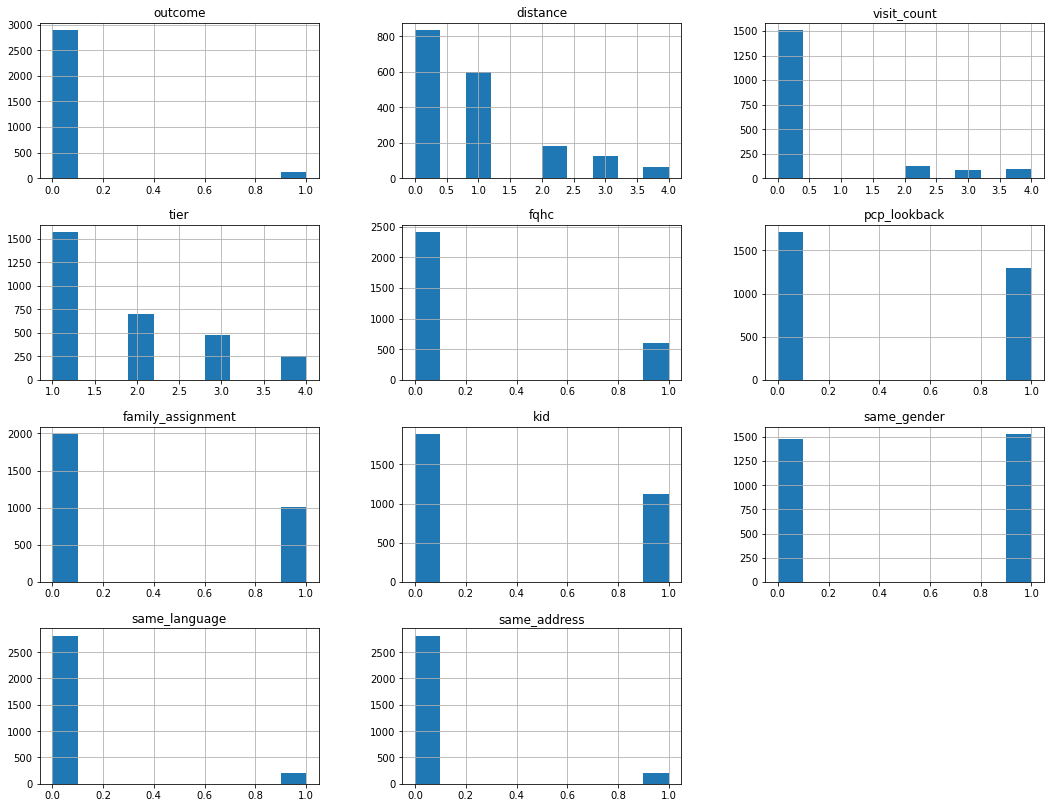

In [60]:
data.hist(figsize=(18,14))

Observations:
*   `outcome`:Data is highly imbalanced i.e data points with class label 0 exceeds the number of data points with label 1.
*   `distance` - the distribution is skewed 
*   `visit_count` - the distribution is skewed
*   Other binary attributes seem to be fairly distributed or slightly skewed





### Check data for skewness

In [49]:
print(data.skew())

outcome              4.659267
distance             4.876756
visit_count          4.778858
tier                 0.903941
fqhc                 1.561988
pcp_lookback         0.232984
family_assignment    0.667141
kid                  0.507856
is_ped               0.441229
same_gender         -0.047320
same_language        3.535541
same_address         3.514287
dtype: float64


As observed from the histogram, `distance` and `visit_count` are highly skewed(right-skewed or positively skewed).<br>
We will apply a logarithm transformation to reduce the skewness.<br>
`log (x+1)` - +1 is included to prevent values from going to infinity

In [50]:
data.distance=data.distance.map(lambda x: np.log(x+1))
data.visit_count=data.visit_count.map(lambda x: np.log(x+1))
print(data.skew())

outcome              4.659267
distance             1.484972
visit_count          2.154438
tier                 0.903941
fqhc                 1.561988
pcp_lookback         0.232984
family_assignment    0.667141
kid                  0.507856
is_ped               0.441229
same_gender         -0.047320
same_language        3.535541
same_address         3.514287
dtype: float64


We have reduced the skewness to a significant extent.

### Outlier Analysis - Detection and removal
We use box plot to check for outliers

<AxesSubplot:>

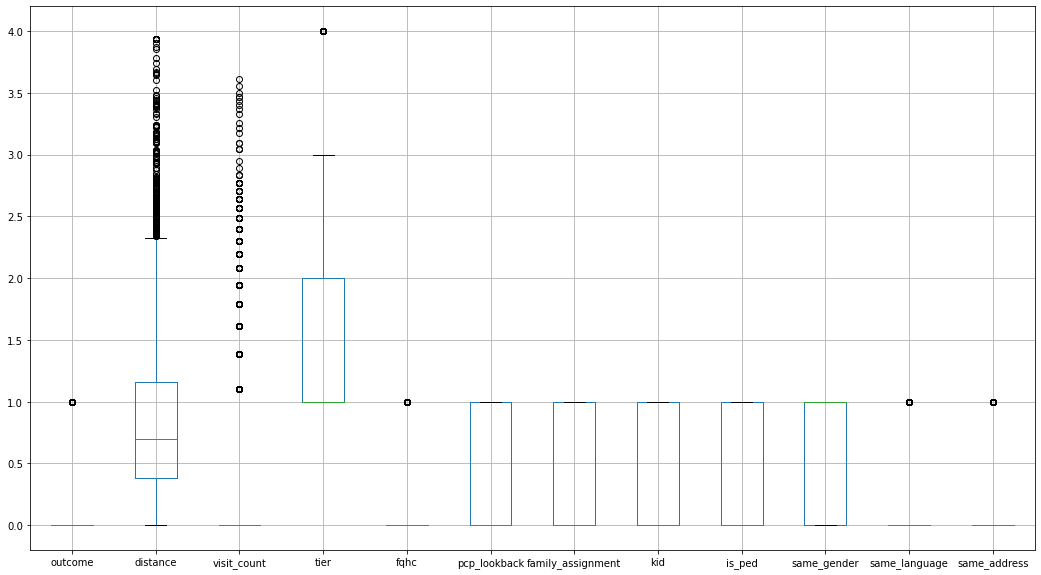

In [51]:
data.boxplot(figsize=(18,10))

In [52]:
distance_outliers=identify_outliers(data,'distance')
visit_count_outliers=identify_outliers(data,'visit_count')
data.drop(distance_outliers,inplace=True)
#Drop the indices that are common for both the outliers
visit_count_outliers=[index for index in visit_count_outliers if index not in distance_outliers] 
data.drop(visit_count_outliers,inplace=True)
print('Removed {} outliers from the dataset'.format(len(distance_outliers)+len(visit_count_outliers)))
print(data.shape)

Removed 123 outliers from the dataset
(3007, 12)


### Correlation analysis

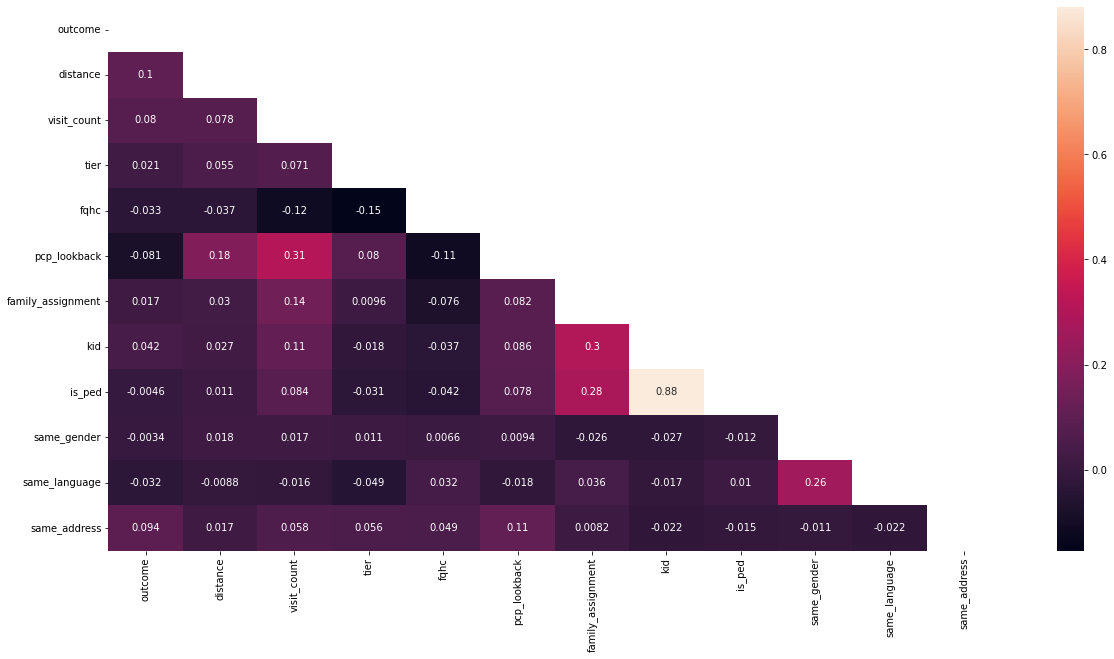

In [53]:
show_heat_map(data)

From the above heatmap, there is a very obvious strong positive correlation.<br>
Features `kid` and `is_ped` are highly correlated, this is due to the fact that if the person is a kid, then the assigned doctor is a pediatrician, hence one of the features can be dropped

In [54]:
data.drop(['is_ped'],axis=1,inplace=True)

## Model Training and testing

### Model Selection

The following models are selected to be evaluated
1.   RandomForestClassifier
2.   Gaussian Naive Bayes Classifier
3.   Logistic Regression
4.   Linear Suport Vector Classification
5.   k Nearest Neighbors
6.   Decision Tree Classifier






In [55]:
models=[{'name':'RandomForest', 'model': RandomForestClassifier()},{'name':'GaussianNB','model':GaussianNB()},{'name':'LogisticRegression','model':LogisticRegression()},{'name':'LinearSVC','model':LinearSVC()},{'name':'kNN','model':KNeighborsClassifier(n_neighbors=10,weights='distance')},{'name':'DecisionTree','model':DecisionTreeClassifier()}]
analysis=[]
for model in models:
  model_training_report=evaluate_model(data,model["model"])
  model_training_report["name"]=model["name"]
  condensed_data=[(item["iteration"],item["f0.5"])for item in model_training_report["stats_by_iteration"]]
  model_training_report["analysis_result"]=condensed_data
  analysis.append(model_training_report)

### Evaluating Performance of the models

We check the performance of the model using the RepeatedStratifiedKFold cross validation technique and record the f0.5 score for each iteration.<br>
We use this data to compare the models.<br>
The reason we use f0.5 score instead of the usual metrics is because the data is imbalanced i.e. class to be learned is the minority class and as the false positives are costly.<br>


Least variance for model {'name': 'LinearSVC', 'variance': 0.5714529599999991, 'max_score': 94.7}


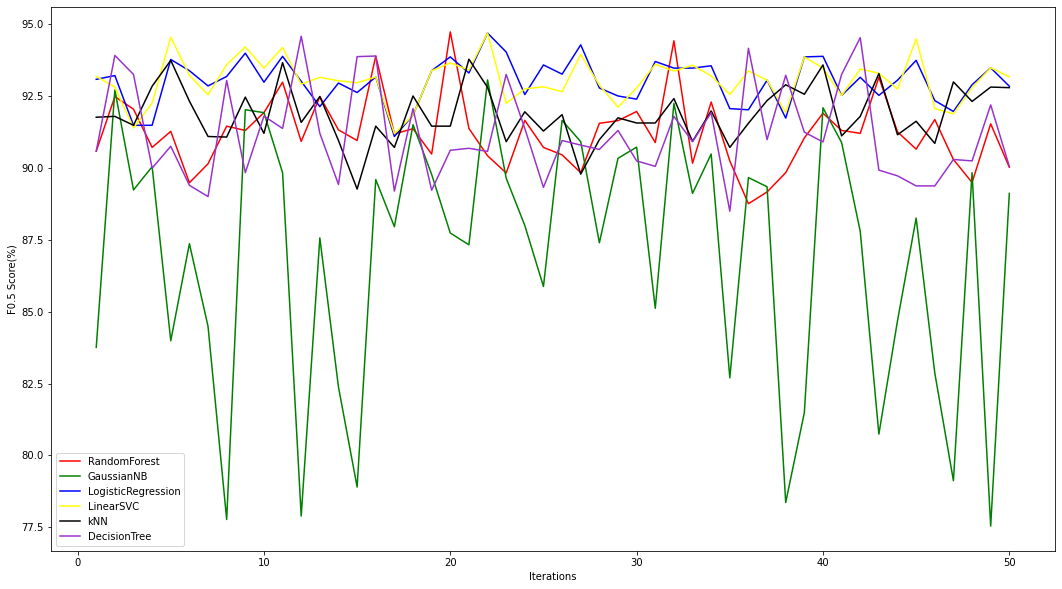

In [56]:
plt.figure(figsize=(18,10))
plt.xlabel('Iterations')
plt.ylabel('F0.5 Score(%)')

colors=["red",'green','blue','yellow','black','darkorchid','lime']
index=0
model_names=[]
variances=[]
for analysis_res in analysis:
  condensed_data = analysis_res["analysis_result"]
  model_names.append(analysis_res['name'])
  percentages=[item[1] for item in condensed_data]
  variances.append({'name':analysis_res['name'],'variance':np.var(percentages),'max_score':max(percentages)})
  plt.plot([item[0] for item in condensed_data],percentages,color=colors[index])
  index+=1
plt.legend(model_names)
variances=sorted(variances,key=lambda x: x['variance'])
print('Least variance for model {}'.format(variances[0]))

Linear Suport Vector Classifier is the model with the least variance across the iterations, meaning that the performance of the model is consistent

In [57]:
chosenModel="LinearSVC"
featureVotes={}
for model in analysis:
  if model["name"]==chosenModel:
    for iteration_stats in model["stats_by_iteration"]:
      for feature in iteration_stats["selected_features"]:
        if feature not in featureVotes:
          featureVotes[feature]=0
        featureVotes[feature]+=1
# print(featureVotes)
selected_features=sorted(featureVotes, key=featureVotes.get,reverse=True)[:6]
print("Top 6 important features are {}".format(selected_features))


Top 6 important features are ['pcp_lookback', 'same_address', 'visit_count', 'same_language', 'distance', 'fqhc']


## Deduction from the data and model

Based on the features that was selected by the model to be most important to label the data, we will inspect the dataset to get some insights.

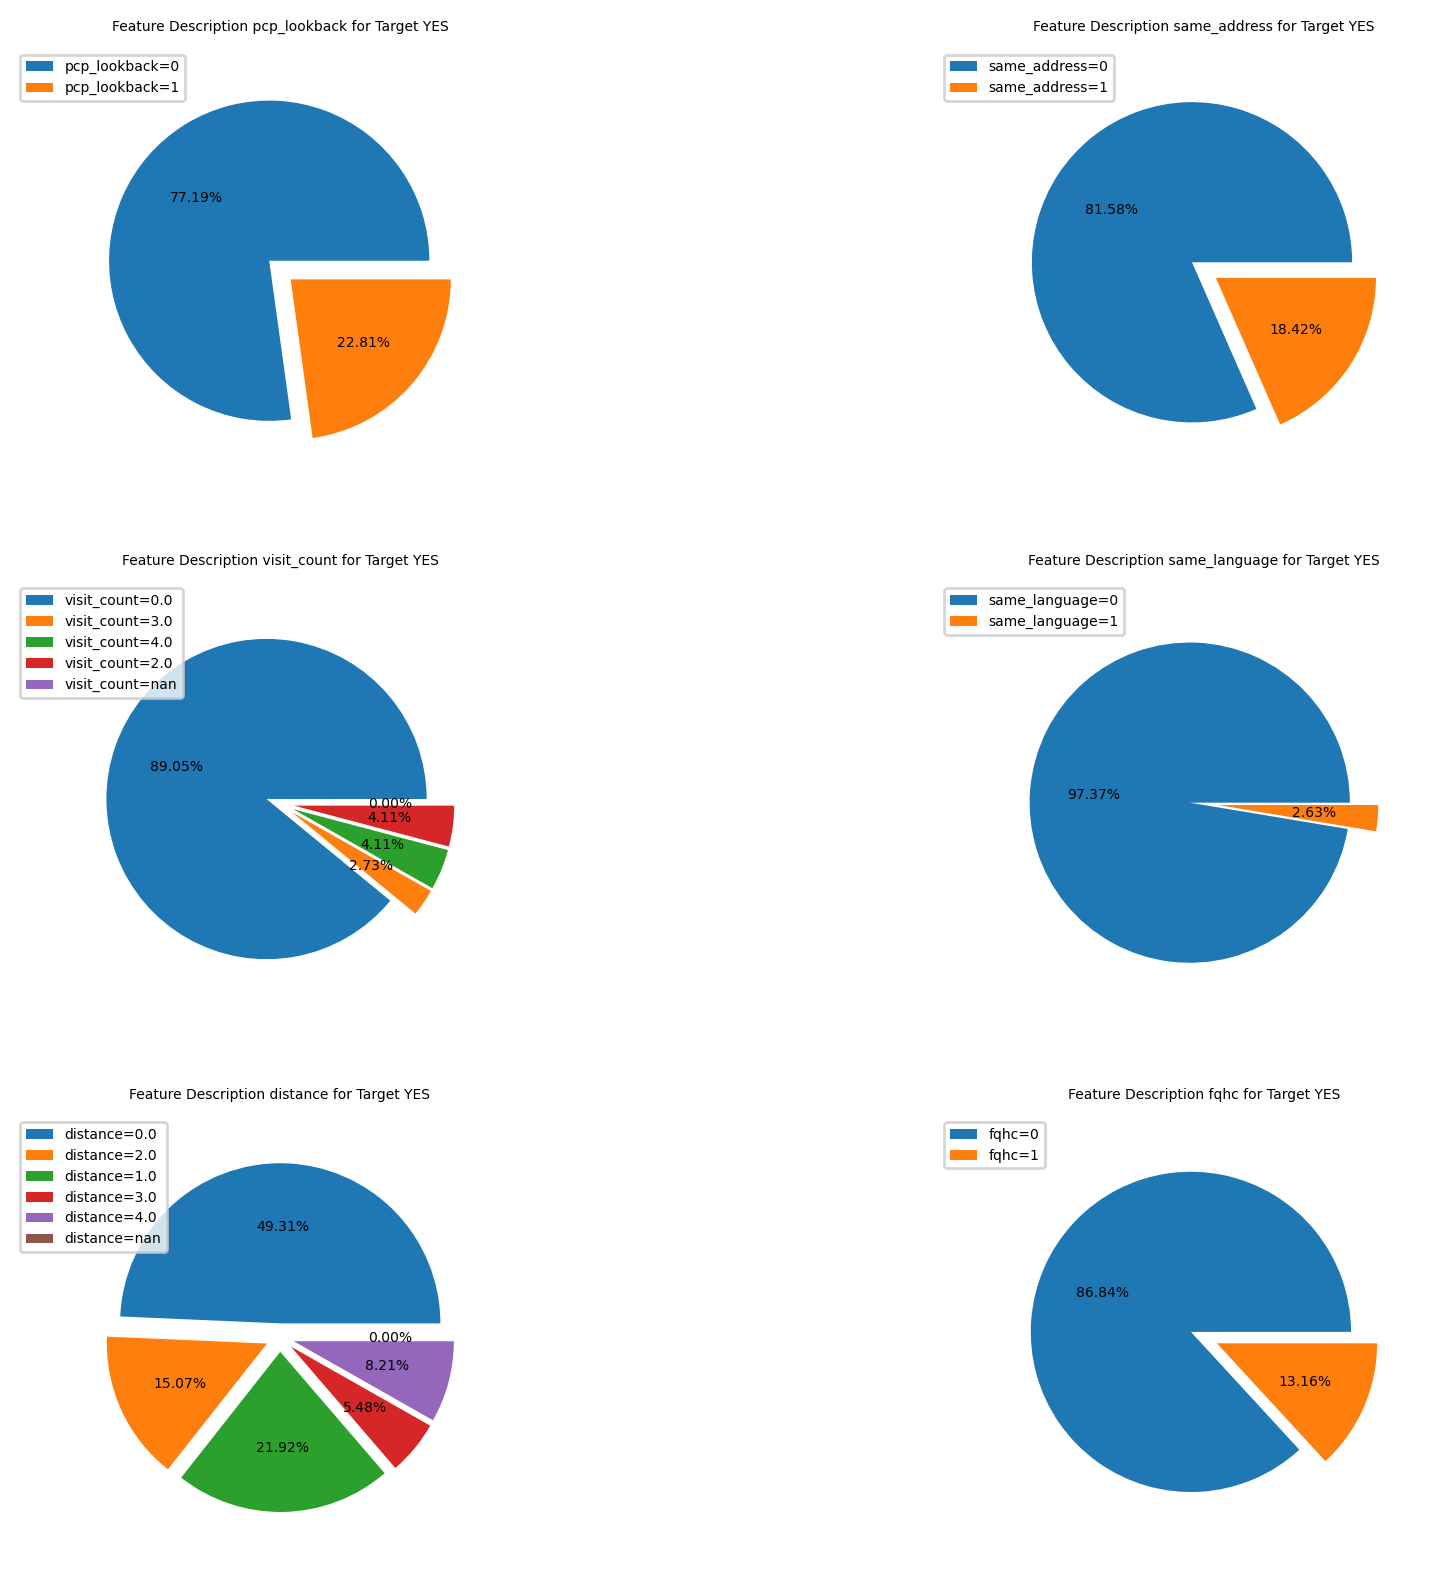

In [58]:
target_label='outcome'
report=compare_features(data,selected_features, target_label)
# print(report)
plot_data_from_report(report)
plt.show()

The above charts represent information regarding why members might have decided to opt for a change.<br>
**Observations:**
*   `pcp_lookback`- If the provider was not the member primary care provider before, it is very likely that the member would opt for a change
*   `same_address`- Out of people who opted for a change, most of them prefer the re-assigned provider to not have  same address as the provider pre-assigned.
*   `visit_count`- If the member visit count is less, then it is very likely that the member would request for a change
*   `same_language`- If the Provider and member do not speak the same language, it is very likely that the member would request for a change
*   `fqhc`- Members prefer a Provider who is a certified Federally Qualified Health Center, else they'd request to change to one.
*   `distance`- This is an intruiging observation, members who stay closer to the provider opt for a change.
The encoded data can be interpreted as:
    *   Very Near
    *   Near
    *   Reachable
    *   Far
    *   Very Far
  <br>People who are VeryNear and Reachable tend to opt for a change than the members belonging to the other group









